Fashion MNIST:
==============

This notebook contain all the code to train, analyse and compare various ML algorithms

let's start with libraries and datasets imports. Note that DistToAverageClassifier is a handmade classifier, that will be used as basis, for algorithm comparison.

In [1]:
import multiprocessing as mp
# data manipulation imports
import pandas as pd
import numpy as np
# classification imports
from lib.ClassifierManager import *
from lib.DistToAverageClassifier import *
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score
# plotting imports
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
sns.set(color_codes=True)

In [2]:
# init the manager, where we will store all the outputs
classification_manager = ClassifierManager()

In [3]:
# load our train and test datasets
train_df = pd.read_csv("datasets/fashion_mnist/fashion-mnist_train.csv")
test_df = pd.read_csv("datasets/fashion_mnist/fashion-mnist_test.csv")

In [4]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB


the differents categories are defined with numbers. Indexes in this array allow the translation between class names and class numbers.

In [5]:
categories = ["T-shirt/top",
              "Trouser",
              "Pullover",
              "Dress",
              "Coat",
              "Sandal",
              "Shirt",
              "Sneaker",
              "Bag",
              "Ankle boot"]

In [6]:
def gen_image(arr):
    """
    function to display an mnist image from it's pixels array
    """
    image = np.array(arr, dtype='float')
    pixels = image.reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.show()


def get_x_y_from_df(df: pd.DataFrame):
    """
    turns a pandas df to X and Y vectors usable by scykitlearn
    :param df: the dataframe
    :return: the X and y vectors needed by scykit
    """
    (n_row, n_col) = df.values.shape
    y = df.values[:, 0]
    X = df.values[:, 1:n_col]
    return X, y


In [7]:
(X_test, y_test) = get_x_y_from_df(test_df)
(X_train, y_train) = get_x_y_from_df(train_df)

Our first classifier
--------------------

In order to compare our results we need a classifier as reference.

the reference classifier works as follow:

training:
 - makes an average of the images by category.

serving:
 - find the category that have the least square error with the given image.

this classifier is not very clever but it gives a good reference of an easly atteignable score.

In [8]:
res = classification_manager.add_classifier(
    "reference", 
    DistToAverageClassifier(), 
    train_df, test_df, get_x_y_from_df)
classification_manager.pretty_print("reference")

* reference *
training time:1.4402831620027428
prediction time:17.95807377700112
report             precision    recall  f1-score   support

          0       0.71      0.70      0.70      1000
          1       0.96      0.90      0.92      1000
          2       0.59      0.50      0.54      1000
          3       0.71      0.80      0.75      1000
          4       0.55      0.60      0.57      1000
          5       0.48      0.76      0.59      1000
          6       0.37      0.20      0.26      1000
          7       0.74      0.79      0.76      1000
          8       0.93      0.76      0.84      1000
          9       0.85      0.85      0.85      1000

avg / total       0.69      0.69      0.68     10000



Trees
-----

Let's try trees! First, we'll train a tree wil the default parameters (no depth limit)

In [9]:
res = classification_manager.add_classifier(
    "tree_depth_max",
    tree.DecisionTreeClassifier(),
    train_df, test_df, get_x_y_from_df)
classification_manager.pretty_print("tree_depth_max")

* tree_depth_max *
training time:44.2511666529972
prediction time:0.01804258199990727
report             precision    recall  f1-score   support

          0       0.73      0.74      0.74      1000
          1       0.95      0.96      0.96      1000
          2       0.68      0.68      0.68      1000
          3       0.83      0.81      0.82      1000
          4       0.68      0.69      0.68      1000
          5       0.91      0.87      0.89      1000
          6       0.55      0.54      0.54      1000
          7       0.86      0.86      0.86      1000
          8       0.91      0.91      0.91      1000
          9       0.89      0.90      0.90      1000

avg / total       0.80      0.80      0.80     10000



impact of the depth
-------------------

We will train various trees at various depth to see the impact of this parameter

In [10]:
depths = range(1, 20)

In [11]:
for i in depths:
    res = classification_manager.add_classifier(
        "tree_depth"+str(i),
        tree.DecisionTreeClassifier(max_depth=i),
        train_df, test_df, get_x_y_from_df)

In [12]:
test_accuracy = []
train_accuracy = []
test_time = []
train_time = []
#classifier_size = []

for i in depths:
    classifier = classification_manager.dict["tree_depth"+str(i)]
    predicted = classifier['predicted_data']
    test_accuracy.append(precision_score(y_test, predicted, average='macro'))
    train_accuracy.append(precision_score(y_train, classifier['instance'].predict(X_train), average='macro'))
    train_time.append(classifier['training_duration'])
    test_time.append(classifier['prediction_duration'])
    #classifier_size.append(utils.get_size(classifier['instance']))

/home/thibaut/usr/vendors/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


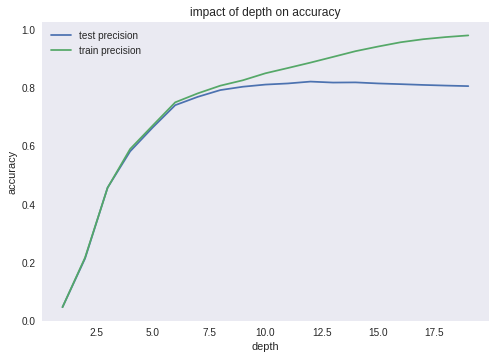

In [13]:
fig, ax = plt.subplots()
ax.plot(depths, test_accuracy, label='test precision')
ax.plot(depths, train_accuracy, label='train precision')
ax.set(xlabel='depth', ylabel='accuracy', title='impact of depth on accuracy')
ax.grid()

plt.legend()
fig.savefig("figs/trees_accuracy.png")
plt.show()


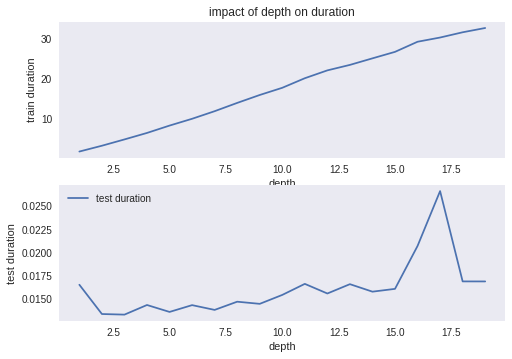

In [14]:
fig, ax = plt.subplots(2)

ax[0].plot(depths, train_time, label='train duration')
ax[0].set(xlabel='depth', ylabel='train duration', title='impact of depth on duration')
ax[0].grid()

ax[1].plot(depths, test_time, label='test duration')
ax[1].set(xlabel='depth', ylabel='test duration')
ax[1].grid()

plt.legend()
fig.savefig("figs/trees_duration.png")
plt.show()

Neural networks
---------------

In [15]:
res = classification_manager.add_classifier(
    "neural_ref",
    MLPClassifier(solver='adam', alpha=1e-5, max_iter=60000, hidden_layer_sizes=(20, 15), random_state=1),
    train_df, test_df, get_x_y_from_df)
classification_manager.pretty_print("neural_ref")

* neural_ref *
training time:56.45219224700122
prediction time:0.028006731998175383
report             precision    recall  f1-score   support

          0       0.81      0.80      0.80      1000
          1       0.99      0.96      0.97      1000
          2       0.83      0.72      0.77      1000
          3       0.83      0.90      0.86      1000
          4       0.74      0.82      0.78      1000
          5       0.94      0.93      0.93      1000
          6       0.60      0.62      0.61      1000
          7       0.94      0.89      0.91      1000
          8       0.97      0.94      0.95      1000
          9       0.90      0.96      0.93      1000

avg / total       0.85      0.85      0.85     10000



In [16]:
N = 5
values_to_try = []
for x, y in np.ndindex((N, N)):
    values_to_try.append(((x + 1) * 5, (y + 1) * 5))


def train_value(value):
    max_iter = 240000
    (width, depth) = value
    key_name = "neural_" + str(width) + "x" + str(depth) + "_iter_"+str(max_iter)
    return classification_manager.add_classifier(
        key_name,
        MLPClassifier(solver='adam', alpha=1e-5, max_iter=max_iter, hidden_layer_sizes=value, random_state=1),
        train_df, test_df, get_x_y_from_df)


In [17]:
for val in values_to_try:
    results = train_value(val)

In [18]:
test_accuracy = np.zeros((N, N))
train_accuracy = np.zeros((N, N))
test_time = np.zeros((N, N))
train_time = np.zeros((N, N))
#classifier_size = []

max_iter = 240000
for (width, depth) in values_to_try:
    x = int(width/5)-1
    y = int(depth/5)-1
    key_name = "neural_" + str(width) + "x" + str(depth) + "_iter_" + str(max_iter)
    classifier = classification_manager.dict[key_name]
    predicted = classifier['predicted_data']
    test_accuracy[x,y] = precision_score(y_test, predicted, average='macro')
    train_accuracy[x,y] = precision_score(y_train, classifier['instance'].predict(X_train), average='macro')
    train_time[x,y] = classifier['training_duration']
    test_time[x,y] = classifier['prediction_duration']
    #classifier_size.append(utils.get_size(classifier['instance']))

/home/thibaut/usr/vendors/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


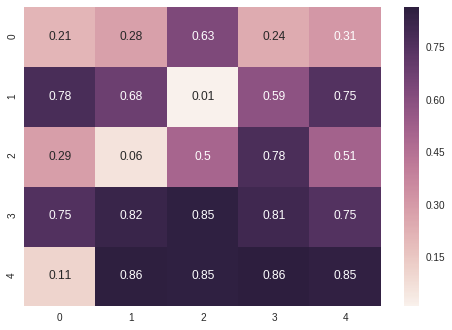

In [19]:
sns.heatmap(test_accuracy, annot=True)
plt.show()

In [21]:
values_to_try = range(40000, 250000, 10000)


def train_value(value):
    max_iter = value
    (width, depth) = (25, 10)
    key_name = "neural_" + str(width) + "x" + str(depth) + "_iter_"+str(max_iter)
    return classification_manager.add_classifier(
        key_name,
        MLPClassifier(solver='adam', alpha=1e-5, max_iter=max_iter, hidden_layer_sizes=value, random_state=1),
        train_df, test_df, get_x_y_from_df)

for val in values_to_try:
    results = train_value(val)


In [ ]:
test_accuracy = []
train_accuracy = []
test_time = []
train_time = []
#classifier_size = []

for i in values_to_try:
    classifier = classification_manager.dict["neural_25x10_iter_"+str(i)]
    predicted = classifier['predicted_data']
    test_accuracy.append(precision_score(y_test, predicted, average='macro'))
    train_accuracy.append(precision_score(y_train, classifier['instance'].predict(X_train), average='macro'))
    train_time.append(classifier['training_duration'])
    test_time.append(classifier['prediction_duration'])
    #classifier_size.append(utils.get_size(classifier['instance']))

In [25]:
from sklearn.model_selection import ShuffleSplit

from lib.PlotLearningCurve import plot_learning_curve

title = "Learning Curve (Neural Network)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = MLPClassifier(solver='adam', alpha=1e-5, max_iter=240000, hidden_layer_sizes=(25,10), random_state=1)

plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=4)
